# 1. Introduction à la R&D

#### Liste de site utiles:
- interface HDFS : http://tlsdbpfitn01:50070/explorer.html#/
- interface Hadoop : http://tlsdbpfitn01:8088/cluster/apps/RUNNING
- monitoring des jobs : http://tlstbenman02:9994/
- ressources disponnibles : http://tlstbenman02:9994/clusage.html

## 1.1 Visualisation des données 

In [1]:
# Importation des bibliothèques

# Biblio Python
import numpy as np
import pandas as pd
import datetime

# Bilbio graphique 
import matplotlib.pyplot as plt
# pour avoir des graph dans la cellule output
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15, 10) # taille de l'image en cm

# Biblio PySpark
import pyspark.sql.functions as sqlf # Dans la présentation j'ai utilisé F, mais comme le reste de l'équipe utilise sqlf...
from pyspark.sql.types import *

# Parametrage du Hive Context
hc = HiveContext(sc)
hc.setConf("hive.exec.dynamic.partition", "true")
hc.setConf("hive.exec.dynamic.partition.mode", "nonstrict")
hc.setConf("hive.exec.max.dynamic.partitions", "15000")
hc.setConf("hive.exec.max.dynamic.partitions.pernode", "15000")
hc.setConf('parquet.compression', 'gzip')

In [2]:
# On crée un objet lié à la table historic_measurement
mes = hc.table('historic_measurement') # Ça peut prendre jusqu'a quelques secondes/dizaines de secondes selon les resources

# On peut ensuite afficher le "schéma" c-à-d le nom et le type de chaque colonne
mes.printSchema()

root
 |-- insertion_date: timestamp (nullable = true)
 |-- last_updated_date: timestamp (nullable = true)
 |-- source: string (nullable = true)
 |-- sar: integer (nullable = true)
 |-- phase: integer (nullable = true)
 |-- sensor: string (nullable = true)
 |-- value: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- aircraft: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- departure_year: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- flight_leg_count: integer (nullable = true)



### 1.1.1 Selection des données
A ce state les données ne sont pas pivotées (pas 1 colonne pas capteur), mais il est déjà possible de selectionner une partie des données en imposant des conditions sur les colonnes.

Colonnes utiles:
- **registration** : immatriculation de l'avion : F-HPJA, F-HPJB, ... jusqu'a F-HPJJ
- **departure_year** : année de départ du vol
- **departure_month** : mois de départ du vol
- **departure_day** : jour de départ du vol
- **flight_leg_count** : "numéro" du vol. Attention, en pratique on ne connait pas le flight_leg_count d'un vol, sauf en regardant précisément dans la table. Ça sert surtout pour différencier deux vols ayant eu lieux le même jour.
- **sensor** : Nom du capteur qui a enregistré la valeur
- **value** : valeur enregistré par le capteur de la colonne **sensor**
- **time** : objet datetime contenant l'information de la date de la prise de la mesure
- **sar** : colonne contenant le numéro du fichier SAR dont provient le capteur. En pratique on l'utilise pour filtrer les capteurs. Soit parce que l'on sait que l'on ne veut que les capteurs du SAR 13 (par exemple), ou soit parce qu'un capteur est enregistré dans deux SARs différents et on ne veut en sélectionner qu'un seul.


### 1.1.2 Exemple de selection 
On veut selectionner les données de certains capteurs (capteurs de température d'huile et courant sur la phase A) qui se trouvent dans le *SAR 28* pour l'avion *F-HPJG*, pour le/les vols du *12 décembre 2017*

In [3]:
# Les capteurs de temperature d'huile
temp_huile = [
    'VFGOIT.1', 'VFGOIT.2','VFGOIT.3','VFGOIT.4'
]

# Les capteurs de courant sur la phase A
cour_phase = [
    '_GGPCUCPA_1', '_GGPCUCPA_2', '_GGPCUCPA_3', '_GGPCUCPA_4'
]

# création d'une liste globale des capteurs
sensors_to_consider = temp_huile + cour_phase

df = mes.where(
    (mes.registration == 'F-HPJG') &
    (mes.departure_year == 2017) &
    (mes.departure_month == 12) &
    (mes.departure_day == 12) &
    (mes.sar == 28) &
    (mes.sensor.isin(sensors_to_consider))
)

In [4]:
# On pivote ensuite les données : c-a-d que l'on crée une colonne par capteur

df_pivot = df.groupBy(
    'registration',
    'departure_year',
    'departure_month',
    'departure_day',
    'flight_leg_count',
    'time'
).pivot('sensor').agg(sqlf.max('value'))

# Selon la taille du dataset a pivoter et les ressources disponnibles, l'oppération peut prendre entre quelques secondes et
# quelques minutes.

Attention : il faut bien mettre toutes les colonnes que l'on veut conserver dans le GroupBy. Si l'on oublie la colonne *departure_month* par exemple, elle n'apparaitra pas dans la table pivotée. Deplus, cela va modifier l'aggrégation. Si l'on oublie de mettre la colonne *time* par exemple, l'aggrégation se fera par flight_leg_count et donc on aura le max d'un sensor par vol. Ce qui n'est pas ce que l'on veut pour le moment !

In [5]:
# On peut visualiser le schema de la nouvelle table :
df_pivot.printSchema()

root
 |-- registration: string (nullable = true)
 |-- departure_year: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- flight_leg_count: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- VFGOIT.1: float (nullable = true)
 |-- VFGOIT.2: float (nullable = true)
 |-- VFGOIT.3: float (nullable = true)
 |-- VFGOIT.4: float (nullable = true)
 |-- _GGPCUCPA_1: float (nullable = true)
 |-- _GGPCUCPA_2: float (nullable = true)
 |-- _GGPCUCPA_3: float (nullable = true)
 |-- _GGPCUCPA_4: float (nullable = true)



In [6]:
# On peut aussi compter le nombre de lignes, pour vérifier que le dataframe n'est pas vide.
df_pivot.count()

315170

In [8]:
# Il est aussi possible de vérifier les vols que l'on a sélectionné via le flight_leg_count :
df_pivot.select("flight_leg_count").distinct().show(truncate=False) #truncate = false pour avoir des colonnes larges

+----------------+
|flight_leg_count|
+----------------+
|664             |
|665             |
+----------------+



ici on a donc 2 vols : le 664 et le 665. C'est bon à savoir pour la suite !

### 1.1.4 renommage des colonnes
Les capteurs ont, dans la table *historic_measurement* le nom qu'ils ont par défaut, qui comporte des "." et des ":". Cependant il est impossile de requêter la table avec des noms contenant des "." et des ":". Il faut donc renommer les colonne et notre liste de capteurs.

In [9]:
# On renomme les colonnes
old_columns = df_pivot.schema.names
new_columns = map(lambda x: x.replace('.','_'), old_columns) # on enlève les "."
new_columns = map(lambda x: x.replace(':','_'), new_columns) # et aussi les ":"

df_pivot_renamed = reduce(lambda df_pivot,
                          idx: df_pivot.withColumnRenamed(old_columns[idx], new_columns[idx]),
                          xrange(len(old_columns)),
                          df_pivot)

# On oublie pas de renommer la liste des capteurs :
sensor_rnmd = map(lambda x: x.replace('.','_').replace(':','_'),sensors_to_consider) # même chose que plus haut mais en 1 étape

# On peut aussi renommer les autres listes
temp_huile = map(lambda x: x.replace('.','_').replace(':','_'),temp_huile) # même chose que plus haut mais en 1 étape
cour_phase = map(lambda x: x.replace('.','_').replace(':','_'),cour_phase) # même chose que plus haut mais en 1 étape

In [10]:
# on vérifie le résultat :
print(sensor_rnmd)
df_pivot_renamed.printSchema()

['VFGOIT_1', 'VFGOIT_2', 'VFGOIT_3', 'VFGOIT_4', '_GGPCUCPA_1', '_GGPCUCPA_2', '_GGPCUCPA_3', '_GGPCUCPA_4']
root
 |-- registration: string (nullable = true)
 |-- departure_year: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- flight_leg_count: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- VFGOIT_1: float (nullable = true)
 |-- VFGOIT_2: float (nullable = true)
 |-- VFGOIT_3: float (nullable = true)
 |-- VFGOIT_4: float (nullable = true)
 |-- _GGPCUCPA_1: float (nullable = true)
 |-- _GGPCUCPA_2: float (nullable = true)
 |-- _GGPCUCPA_3: float (nullable = true)
 |-- _GGPCUCPA_4: float (nullable = true)



#### On a maintenant un dataset sur lequel on peut travailler !

### 1.1.5  Affichage des courbes
Maintenant que notre jeu de données est crée, et qu'il est suffisamment petit pour pouvoir être convertit en Pandas (puisqu'il n'y a qu'un jour de donnée pour un avion sur seulement quelques capteurs), on va pouvoir le visualiser !

In [11]:
# On converti notre DataFrame Spark en Pandas :
dfp = df_pivot_renamed.toPandas()

In [12]:
# On peut afficher le DataFrame
dfp.head()

,registration,departure_year,departure_month,departure_day,flight_leg_count,time,VFGOIT_1,VFGOIT_2,VFGOIT_3,VFGOIT_4,_GGPCUCPA_1,_GGPCUCPA_2,_GGPCUCPA_3,_GGPCUCPA_4
0,F-HPJG,2017,12,12,665,2017-12-13 07:48:58.250,75.0,70.0,67.0,73.0,118.3125,118.500000,87.00000,87.0
1,F-HPJG,2017,12,12,665,2017-12-13 07:49:02.000,75.0,70.0,67.0,73.0,115.8750,124.500000,79.50000,87.0
2,F-HPJG,2017,12,12,665,2017-12-13 07:49:04.000,75.0,70.0,67.0,73.0,112.5000,119.962502,79.40625,87.0
3,F-HPJG,2017,12,12,665,2017-12-13 07:49:08.000,75.0,70.0,67.0,73.0,112.5000,121.500000,85.68750,94.5
4,F-HPJG,2017,12,12,665,2017-12-13 07:49:15.750,75.0,70.0,67.0,73.0,100.5000,121.500000,79.50000,94.5


In [17]:
# Ne pas oublier de tier par la colonne time le DataFrame
dfp = dfp.sort_values('time')

Si ont veut afficher les données d'un vol, il faut le selectionner. En effet, on a vu plus haut qu'il y avait 2 vols : le 664 et le 665

In [18]:
# selection d'un vol :
dfp_664 = dfp.where(dfp.flight_leg_count == 664).dropna()

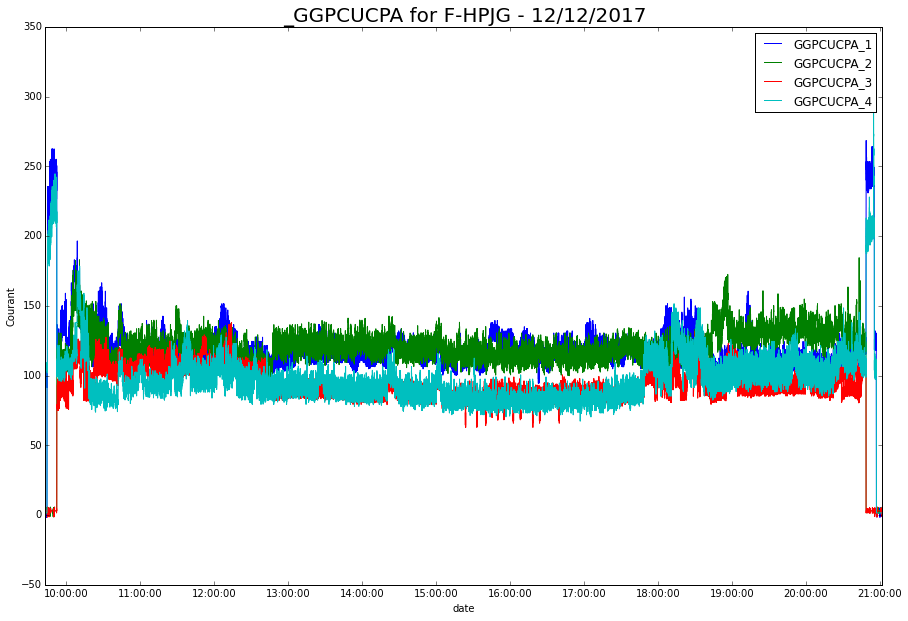

In [21]:
# On peut maintenant afficher les courbes

# for sensor in temp_huile:
#     plt.plot(dfp_664['time'],dfp_664[sensor],label=sensor)
# plt.xlabel('date')
# plt.ylabel('Temperature')
# plt.title("VFGOIT for F-HPJG - 12/12/2017",fontsize=20)
# plt.legend()
# plt.show()

for sensor in cour_phase:
    plt.plot(dfp_664['time'],dfp_664[sensor],label=sensor[1:]) # on enlève le premier caractère "_" pour éviter un bug
plt.xlabel('date')
plt.ylabel('Courant')
plt.title("_GGPCUCPA for F-HPJG - 12/12/2017",fontsize=20)
plt.legend()
plt.show()

In [25]:
pd.DataFrame.rolling?


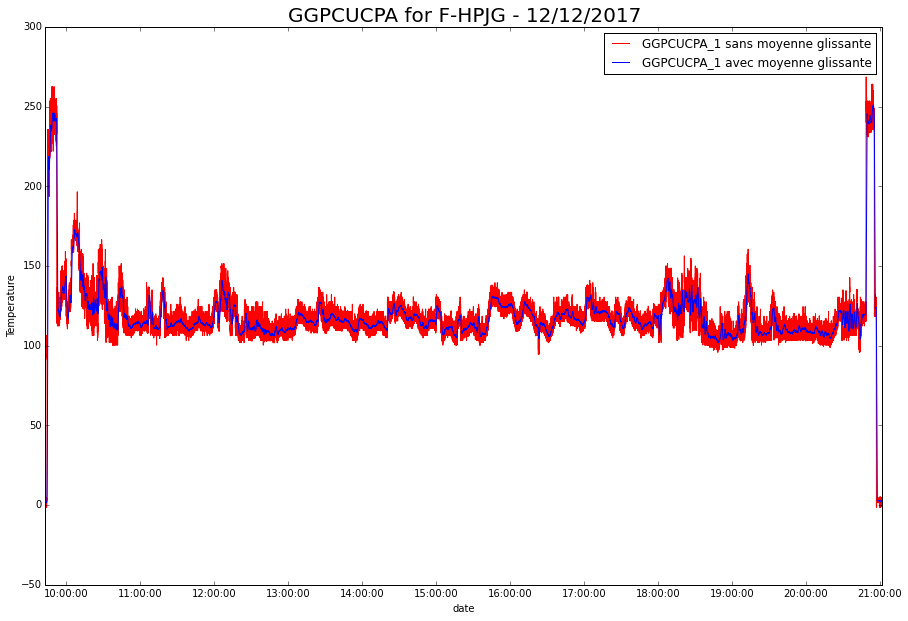

In [128]:
# On peut aussi appliquer une moyenne glissante :

plt.plot(dfp_664['time'],dfp_664['_GGPCUCPA_1'],label='GGPCUCPA_1 sans moyenne glissante',c='r')
plt.plot(dfp_664['time'],dfp_664['_GGPCUCPA_1'].rolling(200).mean(),label='GGPCUCPA_1 avec moyenne glissante',c='b')
plt.xlabel('date')
plt.ylabel('Temperature')
plt.title("GGPCUCPA for F-HPJG - 12/12/2017",fontsize=20)
plt.legend()
plt.show()


## 1.2 Calcul d'indicateur
Maintenant que l'on peut visualiser les courbes, ont peux commencer à les regarger et à avoir des idées d'indicateurs. Imaginons dans un premier temps que notre indicateur soit la moyenne de la température de l'huile, on aimerait le calculer sur une grande période pour voir son évolution.

### 1.2.1 La selection de données
On va selectionner des données, mais cette fois, plus seulement sur un jour mais sur un mois. (vous pourrez essayer de selectionner plus d'un mois, mais plus on selectionne de mois, plus cela peut être long !

In [26]:
#pas de condition sur le departure_day = on prend tous le mois
df = mes.where(
    (mes.registration == 'F-HPJG') &
    (mes.departure_year == 2017) &
    (mes.departure_month == 12) &      # pour selectionner plusieurs mois : (mes.departure_month.isin([1,2,3,4])) par exemple.
    (mes.sar == 28) &
    (mes.sensor.isin(sensors_to_consider))
)

In [27]:
# On pivote ensuite les données #long
df_pivot = df.groupBy(
    'registration',
    'departure_year',
    'departure_month',
    'departure_day',
    'flight_leg_count',
    'time'
).pivot('sensor').agg(sqlf.max('value'))

In [30]:
# On renomme les colonnes
old_columns = df_pivot.schema.names
new_columns = map(lambda x: x.replace('.','_'), old_columns) # on enlève les "."
new_columns = map(lambda x: x.replace(':','_'), new_columns) # et aussi les ":"

df_pivot_renamed = reduce(lambda df_pivot,
                          idx: df_pivot.withColumnRenamed(old_columns[idx], new_columns[idx]),
                          xrange(len(old_columns)),
                          df_pivot)

In [31]:
# On vérifie que tout est bon 
df_pivot_renamed.printSchema()

root
 |-- registration: string (nullable = true)
 |-- departure_year: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- flight_leg_count: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- VFGOIT_1: float (nullable = true)
 |-- VFGOIT_2: float (nullable = true)
 |-- VFGOIT_3: float (nullable = true)
 |-- VFGOIT_4: float (nullable = true)
 |-- _GGPCUCPA_1: float (nullable = true)
 |-- _GGPCUCPA_2: float (nullable = true)
 |-- _GGPCUCPA_3: float (nullable = true)
 |-- _GGPCUCPA_4: float (nullable = true)



### 1.2.2 Les indicateurs
Maintenant que nos données sont prètes, on va créer une liste d'indicateurs à appliquer. Les indicateurs sont céés à partir des focntions d'aggrégation de Spark. Une liste de fonction (pas seulement d'aggrégation) est dispo ici : https://spark.apache.org/docs/1.6.3/api/python/pyspark.sql.html

Dans un premier temps, immaginons que notre indicateur correspond à la moyenne de la température par vol.

In [36]:
# On créer une liste vide qui contiendra les instructions de calcul des indicateurs
exprs = []

# On ajoute les expression pour chaque variable:
for sensor in temp_huile:
    # on utilise la fonction sqlf.mean, pour renommer le résultat on utilise la fonction alias
    exprs.append(sqlf.mean(sensor).alias('MOY_'+sensor))

In [37]:
# On vérifie que c'est bon
for exp in exprs:
    print exp

Column<(avg(VFGOIT_1),mode=Complete,isDistinct=false) AS MOY_VFGOIT_1#681>
Column<(avg(VFGOIT_2),mode=Complete,isDistinct=false) AS MOY_VFGOIT_2#682>
Column<(avg(VFGOIT_3),mode=Complete,isDistinct=false) AS MOY_VFGOIT_3#683>
Column<(avg(VFGOIT_4),mode=Complete,isDistinct=false) AS MOY_VFGOIT_4#684>


### 1.2.3 l'aggrégation
L'aggrégation se passe selon ce qui est défini dans la liste des expressions. Le principe est un peu le même qu'avec le pivot, on doit choisir les colones à garder. En sortie on obtiendra un DataFrame avec les colonnes à garder et les colonnes spécifiées dans la liste des expressions avec le nom donné dans le alias().

On peut convertir le tout en pandas dans la foulée pour obtenir les résultat en local. On peut le faire puisque l'on se retrouve avec un point par indicateur par vol, beaucoup moins qu'avant!

In [38]:
# On fait le groupBy par vol (donc on ne met pas time) #long
dfp = df_pivot_renamed.groupBy(
    'registration',
    'departure_year',
    'departure_month',
    'departure_day',
    'flight_leg_count' 
).agg(*exprs).toPandas()

L'aggrégation des données peut prendre un peu de temps. il est possible de voir la progression sur : http://tlsdbpfitn01:8088/cluster/apps/RUNNING 

Il faut regarder l'application qui porte le nom de votre notebook ( ex: rd_super_notebook ) et cliquer sur ApplicationMaster dans la colonne Tracking UI. Vous verrez la progression des jobs.

In [43]:
# On vérifie que tout est bon
dfp

,registration,departure_year,departure_month,departure_day,flight_leg_count,MOY_VFGOIT_1,MOY_VFGOIT_2,MOY_VFGOIT_3,MOY_VFGOIT_4
0,F-HPJG,2017,12,15,670,74.441583,72.733227,70.424976,72.384790
1,F-HPJG,2017,12,10,661,73.507278,72.372911,70.872001,70.247947
2,F-HPJG,2017,12,10,662,72.120939,68.886974,66.278544,68.693635
3,F-HPJG,2017,12,31,689,73.194979,73.594641,70.877972,73.480247
4,F-HPJG,2017,12,5,659,14.767689,13.000000,13.000000,13.000000
5,F-HPJG,2017,12,26,687,73.245786,70.340061,67.857287,73.420746
6,F-HPJG,2017,12,16,671,73.400808,74.169823,71.651003,70.214568
7,F-HPJG,2017,12,16,672,71.865342,71.756162,68.808555,69.555986
8,F-HPJG,2017,12,11,663,74.603875,72.126630,69.847940,72.164127
9,F-HPJG,2017,12,1,653,73.280759,70.405446,70.190777,71.111194


### 1.2.4 Sauvegarde
Comme générer les indicateurs peut être long, c'est une bonne idée de sauvegarder le DataFrame pandas pour économiser du temps !

In [40]:
# On sauvegarde le DataFrame en indicant le chemin !
dfp.to_pickle('./indicateur_moyenne.pkl')

In [138]:
# Pour lire un DataFrame sauvegardé, on lit le fichier pickle :
dfp = pd.read_pickle('./indicateur_moyenne.pkl')

### 1.2.4 Ajout de la date et tri
Comme on s'interresse à l'évolution de nos indicateurs, on veut leur ajouter un objet datetime pour pouvoir les trier et afficher via cette date

In [45]:
pd.DataFrame.apply?

In [46]:
# Ajout de la colonne date basé sur les colonnes departure_year, departure_month et departure_day
# on converti les colonnes en int car elle sont en float et datetime... et bien datetime il n'aime pas les floats!
dfp['date'] = dfp.apply(
    lambda x : datetime.datetime(
        int(x['departure_year']),
        int(x['departure_month']),
        int(x['departure_day'])
    ),
    axis=1 # on précise sur quel axe on applique la fonction
)

In [47]:
# On trie et on vérifie que tout est bon
dfp = dfp.sort_values('date')
dfp.head() # Pensez à scroller pour voir toutes les colonnes

,registration,departure_year,departure_month,departure_day,flight_leg_count,MOY_VFGOIT_1,MOY_VFGOIT_2,MOY_VFGOIT_3,MOY_VFGOIT_4,date
9,F-HPJG,2017,12,1,653,73.280759,70.405446,70.190777,71.111194,2017-12-01
10,F-HPJG,2017,12,1,654,74.051659,72.781053,72.081817,71.443993,2017-12-01
15,F-HPJG,2017,12,2,655,70.446268,71.900259,72.259025,67.793966,2017-12-02
18,F-HPJG,2017,12,3,656,72.498633,70.825010,69.913058,69.743443,2017-12-03
24,F-HPJG,2017,12,4,658,73.200907,69.638938,67.981403,70.279670,2017-12-04


### 1.2.5 Affichage des indicateurs

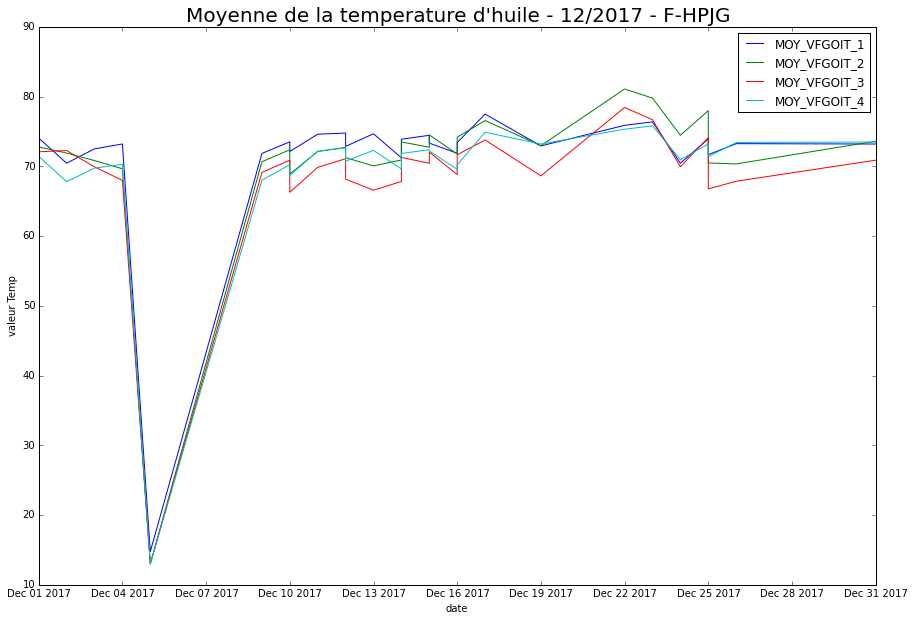

In [141]:
for sensor in temp_huile :
    plt.plot(dfp['date'],dfp['MOY_'+sensor],label='MOY_'+sensor)
plt.xlabel('date')
plt.ylabel('valeur Temp')
plt.title("Moyenne de la temperature d'huile - 12/2017 - F-HPJG",fontsize=20)
plt.legend()
plt.show()

### 1.2.6 Indicateur plus complexes
Que faire si l'on veut créer des indicateurs un peu plus complexes que la moyenne ? On peut créer des colonnes temporaires qui stockent des informations qui nous serviront pour d'autres calculs.

Imaginons que pour les capteur de courant **_GGPCUCPA**, on désire calculer l'écart type de la différence d'un capteur et de la moyenne de ces capteurs.

In [48]:
# Petite introduction à la fonction reduce. Elle permet de combiner des resultats avec une fonction :
a = [1, 1, 1, 1]

# On importe la fonction add
from operator import add

# On additionne tous les éléments de a 
# on va obtenir ( a[0] + (a[1] + (a [2] + a[3]) ) ) = (1+(1+(1+1)) = 4
b = reduce(add,a)
print b

# Pour calculer la moyenne il faut diviser le resultat du reduce par la taille de la liste!

4


In [57]:
# pour créer la moyenne on va procéder de la même façon
# On crée une colonne qui est la moyenne des capteurs de courant avec la commande withColumn

# La fonction sqlf.col permet de faire référence à la colonne du DataFrame
# La fonction sqlf.lit crée une colonne constante 
# La fonction map permet d'appliquer la fonction sqlf.col à tous les éléments de la liste

#df2 = df_pivot_renamed.withColumn('MOYENNE_COURANT', sqlf.col('VFGOIT_1')>10)

df2 = df_pivot_renamed.withColumn('MOYENNE_COURANT',reduce(add, map(sqlf.col,cour_phase)) / sqlf.lit(len(cour_phase)) )

In [58]:
# On vérifie que tout est bon
df2.printSchema()

root
 |-- registration: string (nullable = true)
 |-- departure_year: integer (nullable = true)
 |-- departure_month: integer (nullable = true)
 |-- departure_day: integer (nullable = true)
 |-- flight_leg_count: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- VFGOIT_1: float (nullable = true)
 |-- VFGOIT_2: float (nullable = true)
 |-- VFGOIT_3: float (nullable = true)
 |-- VFGOIT_4: float (nullable = true)
 |-- _GGPCUCPA_1: float (nullable = true)
 |-- _GGPCUCPA_2: float (nullable = true)
 |-- _GGPCUCPA_3: float (nullable = true)
 |-- _GGPCUCPA_4: float (nullable = true)
 |-- MOYENNE_COURANT: double (nullable = true)



In [70]:
# On crée une liste d'aggrégateurs
exprs2 = []

for sensor in cour_phase:
    exprs2.append(sqlf.stddev(sqlf.col(sensor) - sqlf.col('MOYENNE_COURANT')).alias('INDICATEUR_'+sensor))
    
# Et on vérifie que tout est ok
for exp in exprs2:
    print exp

Column<(stddev_samp((_GGPCUCPA_1 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_1#1897>
Column<(stddev_samp((_GGPCUCPA_2 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_2#1908>
Column<(stddev_samp((_GGPCUCPA_3 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_3#1919>
Column<(stddev_samp((_GGPCUCPA_4 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_4#1930>


In [71]:
# On peut procéder à l'aggrégation
dfp = df2.groupBy(
    'registration',
    'departure_year',
    'departure_month',
    'departure_day',
    'flight_leg_count' 
).agg(*exprs2).toPandas()

In [72]:
# On applique le traitement précédent et on peut regarder le DataFrame
dfp['date'] = dfp.apply(lambda x : datetime.datetime(
                                                    int(x['departure_year']),
                                                    int(x['departure_month']),
                                                    int(x['departure_day'])),axis=1 )
dfp = dfp.sort_values('date')
dfp.head()

,registration,departure_year,departure_month,departure_day,flight_leg_count,INDICATEUR__GGPCUCPA_1,INDICATEUR__GGPCUCPA_2,INDICATEUR__GGPCUCPA_3,INDICATEUR__GGPCUCPA_4,date
9,F-HPJG,2017,12,1,653,16.139036,16.105247,17.968535,16.880998,2017-12-01
10,F-HPJG,2017,12,1,654,9.061645,10.525472,12.675692,12.391901,2017-12-01
15,F-HPJG,2017,12,2,655,15.466768,15.448622,21.464102,17.111784,2017-12-02
18,F-HPJG,2017,12,3,656,18.994806,18.349313,19.945799,18.197439,2017-12-03
24,F-HPJG,2017,12,4,658,10.028151,11.550989,15.264222,13.213879,2017-12-04


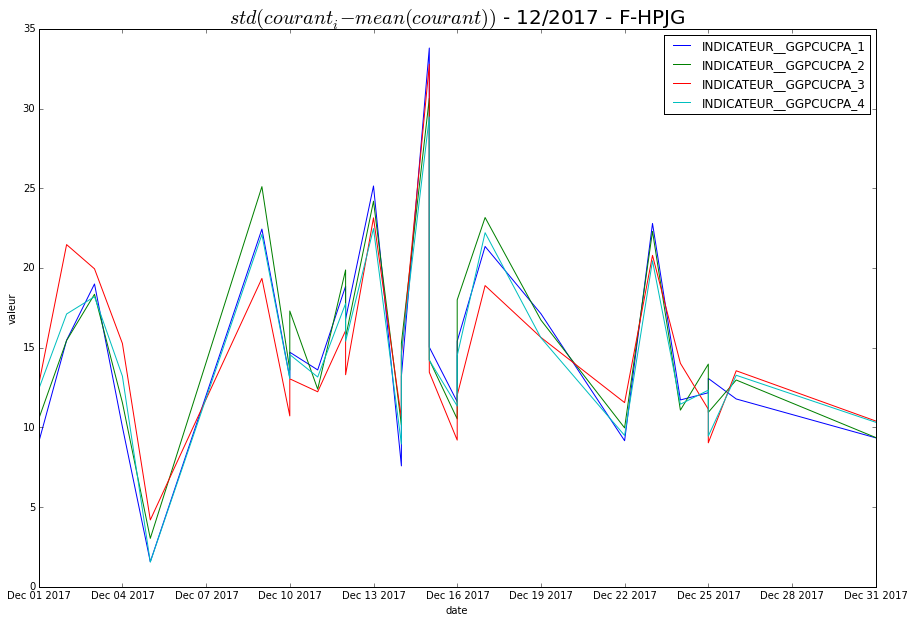

In [148]:
# On peut ensuite tracer les indicateurs
for sensor in cour_phase :
    plt.plot(dfp['date'],dfp['INDICATEUR_'+sensor],label='INDICATEUR_'+sensor)
plt.xlabel('date')
plt.ylabel('valeur')
plt.title("$std(courant_i - mean(courant))$ - 12/2017 - F-HPJG",fontsize=20)
plt.legend()
plt.show()

### 1.2.7 Calculer plusieurs indicateurs d'un coup
c'est possible de calcuper plusieurs indicateur d'un coup si jamais ils n'ont pas le même nom

In [149]:
# On crée une liste qui est contient tous les indicateurs que l'on veut calculer
exprs3 = exprs + exprs2

for exp in exprs3:
    print exp

Column<(avg(VFGOIT_1),mode=Complete,isDistinct=false) AS MOY_VFGOIT_1#1967>
Column<(avg(VFGOIT_2),mode=Complete,isDistinct=false) AS MOY_VFGOIT_2#1968>
Column<(avg(VFGOIT_3),mode=Complete,isDistinct=false) AS MOY_VFGOIT_3#1969>
Column<(avg(VFGOIT_4),mode=Complete,isDistinct=false) AS MOY_VFGOIT_4#1970>
Column<(stddev_samp((_GGPCUCPA_1 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_1#2200>
Column<(stddev_samp((_GGPCUCPA_2 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_2#2211>
Column<(stddev_samp((_GGPCUCPA_3 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_3#2222>
Column<(stddev_samp((_GGPCUCPA_4 - MOYENNE_COURANT),0,0),mode=Complete,isDistinct=false) AS INDICATEUR__GGPCUCPA_4#2233>


In [150]:
# On aggrège les données
dfp = df2.groupBy(
    'registration',
    'departure_year',
    'departure_month',
    'departure_day',
    'flight_leg_count' 
).agg(*exprs3).toPandas()

In [151]:
dfp['date'] = dfp.apply(lambda x : datetime.datetime(
                                                    int(x['departure_year']),
                                                    int(x['departure_month']),
                                                    int(x['departure_day'])),axis=1 )
dfp = dfp.sort_values('date')
# En afficant le DataFrame, on voit que l'on a nos 2 jeux d'indicateurs d'un coup!
dfp.head()

,registration,departure_year,departure_month,departure_day,flight_leg_count,MOY_VFGOIT_1,MOY_VFGOIT_2,MOY_VFGOIT_3,MOY_VFGOIT_4,INDICATEUR__GGPCUCPA_1,INDICATEUR__GGPCUCPA_2,INDICATEUR__GGPCUCPA_3,INDICATEUR__GGPCUCPA_4,date
9,F-HPJG,2017,12,1,653,73.280759,70.405446,70.190777,71.111194,16.139036,16.105247,17.968535,16.880998,2017-12-01
10,F-HPJG,2017,12,1,654,74.051659,72.781053,72.081817,71.443993,9.061645,10.525472,12.675692,12.391901,2017-12-01
15,F-HPJG,2017,12,2,655,70.446268,71.900259,72.259025,67.793966,15.466768,15.448622,21.464102,17.111784,2017-12-02
18,F-HPJG,2017,12,3,656,72.498633,70.825010,69.913058,69.743443,18.994806,18.349313,19.945799,18.197439,2017-12-03
24,F-HPJG,2017,12,4,658,73.200907,69.638938,67.981403,70.279670,10.028151,11.550989,15.264222,13.213879,2017-12-04


In [113]:
# On peut les afficher mais surtout les sauvegarder !
dfp.to_pickle('./indicateurs_F-HPJG.pkl')